In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
frames = np.load("frame_dataset.npy")
frames = np.nan_to_num(frames)

In [3]:
patterns = np.load("pattern_images.npy")
i_patterns = 1-patterns
patterns = np.append(patterns,i_patterns,axis=0)

locs = np.load("pattern_locations.npy")
locs = np.append(locs,locs,axis=0)
locs[:,1] = (1- locs[:,1]) - locs[:,0]
#locs[:,1] = (1-locs[:,1])

In [4]:
locs

array([[0.47619048, 0.5       ],
       [0.38139535, 0.55813953],
       [0.26771654, 0.68503937],
       ...,
       [0.35744681, 0.61276596],
       [0.50314465, 0.45283019],
       [0.3627451 , 0.58823529]])

In [5]:
patterns.shape,locs.shape,frames.shape

((80000, 96), (80000, 2), (1465342, 96))

In [6]:
train_list = np.linspace(0,frames.shape[0]-1,16000,dtype = np.int32)
test_list = np.linspace(random.randint(1,9),frames.shape[0]-1,4000,dtype = np.int32)
common_images = train_list.shape[0]+test_list.shape[0]-np.unique(np.append(train_list,test_list)).shape[0]
"Common image num is ",common_images

('Common image num is ', 38)

In [7]:
frames_train = np.array(frames[train_list])
frames_test = np.array(frames[test_list])

frames_train_target = np.zeros((frames_train.shape[0],4)) 
frames_test_target = np.zeros((frames_test.shape[0],4))

frames_train_loc = np.zeros((frames_train.shape[0],2)) 
frames_test_loc = np.zeros((frames_test.shape[0],2))

#frames_train_target[:,0]=1
#frames_test_target[:,0]=1

In [8]:
pattern_targets = np.zeros((patterns.shape[0],4))
pattern_locs = np.array(locs)

indexes = np.arange(0,patterns.shape[0])
np.random.shuffle(indexes)

pattern_targets[:int(10000),0] = 1
pattern_targets[int(10000):20000,1] = 1
pattern_targets[int(20000):30000,2] = 1
pattern_targets[30000:40000,3] = 1

pattern_targets[40000:50000,0] = 1
pattern_targets[50000:60000,1] = 1
pattern_targets[60000:70000,2] = 1
pattern_targets[70000:80000,3] = 1

pattern_images_train = np.array(patterns[indexes[:64000]])
pattern_images_test = np.array(patterns[indexes[64000:]])

pattern_targets_train = np.array(pattern_targets[indexes[:64000]])
pattern_targets_test = np.array(pattern_targets[indexes[64000:]])

pattern_targets_loc = np.array(pattern_locs[indexes[:64000]])
pattern_tests_loc = np.array(pattern_locs[indexes[64000:]])

In [9]:
pattern_images_train.shape,pattern_images_test.shape,pattern_targets_train.shape,pattern_targets_test.shape,pattern_targets_loc.shape,pattern_tests_loc.shape

((64000, 96), (16000, 96), (64000, 4), (16000, 4), (64000, 2), (16000, 2))

In [10]:
x_train = np.vstack([frames_train,pattern_images_train])
y_train = np.vstack([frames_train_target,pattern_targets_train])
y_train_locs = np.vstack([frames_train_loc,pattern_targets_loc])

x_test = np.vstack([frames_test,pattern_images_test])
y_test = np.vstack([frames_test_target,pattern_targets_test])
y_test_locs = np.vstack([frames_test_loc,pattern_tests_loc])

In [11]:
x_train.shape,y_train.shape,y_train_locs.shape,x_test.shape,y_test.shape,y_test_locs.shape

((80000, 96), (80000, 4), (80000, 2), (20000, 96), (20000, 4), (20000, 2))

In [12]:
x_train.shape,y_train.shape,y_train_locs.shape,x_test.shape,y_test.shape

((80000, 96), (80000, 4), (80000, 2), (20000, 96), (20000, 4))

In [13]:
x_train = (x_train-0.5)*2
x_test = (x_test-0.5)*2

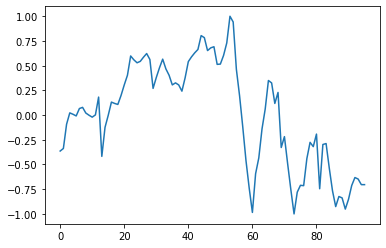

In [14]:
plt.plot(x_train[random.randint(16000,x_train.shape[0]-1)])

In [15]:
def iou_loss(y_true,y_pred):
    min_min = tf.math.minimum(y_true[...,0],y_pred[...,0])
    max_min = tf.math.maximum(y_true[...,0],y_pred[...,0])

    min_max = tf.math.minimum(y_true[...,0]+y_true[...,1],y_pred[...,0]+y_pred[...,1])
    max_max = tf.math.maximum(y_true[...,0]+y_true[...,1],y_pred[...,0]+y_pred[...,1])

    _div = tf.math.divide_no_nan((min_max - max_min),(max_max - min_min))
    _loss = tf.math.reduce_mean(_div)
    return 1-_loss

In [16]:
def conv_block(_input,_filters,_kernel,_pooling):
    c = keras.layers.ZeroPadding1D(padding=(1,1))(_input)
    c  = keras.layers.LocallyConnected1D(_filters,kernel_size = _kernel,padding="valid",activation="relu")(c)
    c  = keras.layers.BatchNormalization()(c)

    c = keras.layers.ZeroPadding1D(padding=(1,1))(c)
    c  = keras.layers.LocallyConnected1D(_filters,strides=1,kernel_size = _kernel,padding="valid",activation="relu")(c)
    c = keras.layers.MaxPooling1D(_pooling)(c)
    c  = keras.layers.BatchNormalization()(c)
    
    return c

In [17]:
def create_model():
    
    i = keras.layers.Input(shape = (96,))
    e = keras.layers.Reshape((96,1))(i)
    
    e = conv_block(_input = e,_filters = 4,_kernel = 3,_pooling = 2)
    #  48 

    e = conv_block(_input = e,_filters = 8,_kernel = 3,_pooling = 2)
    #  24 

    e3 = conv_block(_input = e,_filters = 16,_kernel = 3,_pooling = 2)    
    #  12 

    e2 = conv_block(_input = e3,_filters = 32,_kernel = 3,_pooling = 2)    
    #  6 

    e1 = conv_block(_input = e2,_filters = 64,_kernel = 3,_pooling = 2)    
    #  3 

    e0 = conv_block(_input = e1,_filters = 128,_kernel = 3,_pooling = 3)    
    #  3 

    e0 = keras.layers.Conv1D(96,kernel_size = 1,activation = "relu",padding="same")(e0)
    e0 = keras.layers.Flatten()(e0)

    e1 = keras.layers.Conv1D(32,kernel_size = 1,activation = "relu",padding="same")(e1)
    e1 = keras.layers.Flatten()(e1)

    e2 = keras.layers.Conv1D(16,kernel_size = 1,activation="relu",padding="same")(e2)
    e2 = keras.layers.Flatten()(e2)

    e3 = keras.layers.Conv1D(8,kernel_size = 1,activation="relu",padding="same")(e3)
    e3 = keras.layers.Flatten()(e3)

    e0 = tf.expand_dims(e0,axis = -2)
    e1 = tf.expand_dims(e1,axis = -2)
    e2 = tf.expand_dims(e2,axis=-2)
    e3 = tf.expand_dims(e3,axis=-2)

    e = keras.layers.Concatenate(axis=-2)([e0,e1,e2,e3])#([e0,e1,e2,e3]) , axis=-2

    c = keras.layers.Conv1D(192,kernel_size = 3,activation = "relu",padding="same")(e)
    c = keras.layers.BatchNormalization()(c)

    c = keras.layers.Conv1D(96,kernel_size = 1,activation = "relu")(c)
    c = keras.layers.BatchNormalization()(c)

    c = keras.layers.Conv1D(1,kernel_size = 1,activation="sigmoid")(c)
    c = keras.layers.Flatten()(c)

    d = keras.layers.Conv1D(192,kernel_size = 3,activation = "relu",padding="same")(e)
    d = keras.layers.BatchNormalization()(d)

    d = keras.layers.Conv1D(96,kernel_size = 1,activation = "relu")(d)
    d = keras.layers.BatchNormalization()(d)
    
    d = keras.layers.Conv1D(192,kernel_size = 3,activation = "relu")(d)
    d = keras.layers.BatchNormalization()(d)

    d = keras.layers.Conv1D(96,kernel_size = 1,activation = "relu")(d)
    d = keras.layers.BatchNormalization()(d)

    d = keras.layers.Conv1D(1,kernel_size = 1,activation="relu")(d)
    d = keras.layers.Flatten()(d)
    
    
    model = keras.models.Model(inputs = i, outputs = [c,d])
    model.compile(loss = [keras.losses.binary_crossentropy,iou_loss],optimizer = keras.optimizers.Adam(1e-3))
    return model



In [18]:
tf.keras.backend.clear_session()

In [19]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 96, 1)        0           ['input_1[0][0]']                
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 98, 1)       0           ['reshape[0][0]']                
                                                                                                  
 locally_connected1d (LocallyCo  (None, 96, 4)       1536        ['zero_padding1d[0][0]']         
 nnected1D)                                                                                   

In [89]:
model.fit(x_train[range(0,x_train.shape[0],1)],[y_train[range(0,x_train.shape[0],1)].squeeze(),y_train_locs[range(0,x_train.shape[0],1)]],validation_data=(x_test,[y_test,y_test_locs]),epochs = 10,verbose = 1,shuffle = True,batch_size=64)

Epoch 1/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2274 - flatten_4_loss: 0.0036 - flatten_5_loss: 0.2238 - val_loss: 0.2300 - val_flatten_4_loss: 0.0059 - val_flatten_5_loss: 0.2241
Epoch 2/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2284 - flatten_4_loss: 0.0044 - flatten_5_loss: 0.2240 - val_loss: 0.2290 - val_flatten_4_loss: 0.0053 - val_flatten_5_loss: 0.2237
Epoch 3/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2239 - flatten_4_loss: 0.0026 - flatten_5_loss: 0.2213 - val_loss: 0.2297 - val_flatten_4_loss: 0.0074 - val_flatten_5_loss: 0.2223
Epoch 4/10
1250/1250 [==============================] - 31s 25ms/step - loss: 0.2238 - flatten_4_loss: 0.0025 - flatten_5_loss: 0.2213 - val_loss: 0.2413 - val_flatten_4_loss: 0.0104 - val_flatten_5_loss: 0.2309
Epoch 5/10
1250/1250 [==============================] - 30s 24ms/step - loss: 0.2240 - flatten_4_loss: 0.0026 - flatten_5_loss: 0.2214 - val_loss: 0.225

In [ ]:
model.evaluate(x_test[:4000],[y_test[:4000],y_test_locs[:4000]])
model.evaluate(x_test[4000:],[y_test[4000:],y_test_locs[4000:]])

500/500 [==============================] - 1s 3ms/step - loss: 0.0145 - flatten_4_loss: 0.0043 - flatten_5_loss: 0.0102


[0.014516952447593212, 0.004298131447285414, 0.010218823328614235]

In [232]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 1e-4)

In [98]:
model.save("models/classification_model")

INFO:tensorflow:Assets written to: models/classification_model/assets


In [30]:
classifications_=model.predict(x_test)

In [362]:
inn = random.randint(0,x_test.shape[0]-1)
print(classifications_[inn])
plt.plot(x_test[inn])
plt.show()

IndexError: list index out of range

In [90]:
list_=np.arange(0,100000,10)
print(train_list.shape[0]+list_.shape[0]-np.unique(np.append(train_list,list_)).shape[0])
predictions_=model.predict((frames[list_]-0.5)*2)

107


In [91]:
threshold = 0.9
u_t=np.where(predictions_[0]>threshold)[0]
np.where(predictions_[0][:,0]>threshold)[0].shape,np.where(predictions_[0][:,1]>threshold)[0].shape,np.where(predictions_[0][:,2]>threshold)[0].shape,np.where(predictions_[0][:,3]>threshold)[0].shape

((10,), (44,), (6,), (34,))

[3.4515734e-12 9.9999982e-01 7.0805145e-10 2.7177724e-16]


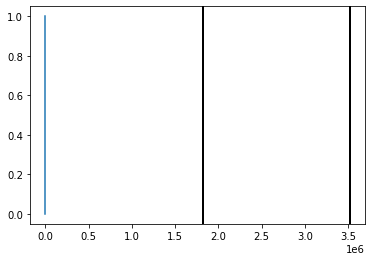

In [92]:
inn = random.randint(0,u_t.shape[0]-1)
print(predictions_[0][u_t[inn]])
#plt.axhline(frames[list_[u_t[inn]],int(predictions_[1][u_t[inn]]*96)],color="black",linewidth = 2)
plt.axvline(predictions_[1][u_t[inn],0]*96,color="black",linewidth = 2)
plt.axvline((predictions_[1][u_t[inn],0]+predictions_[1][u_t[inn],1])*96,color="black",linewidth = 2)
plt.plot(frames[list_[u_t[inn]]])
plt.show()

In [93]:
input_data = np.load("live_test/frames.npy")
input_data = (input_data-0.5)*2

In [94]:
classifications = model.predict(input_data)

In [95]:
_threshold = 0.9
np.where(classifications[0][:,0]>_threshold)[0].shape,np.where(classifications[0][:,1]>_threshold)[0].shape,np.where(classifications[0][:,2]>_threshold)[0].shape,np.where(classifications[0][:,3]>_threshold)[0].shape

((5,), (111,), (28,), (138,))

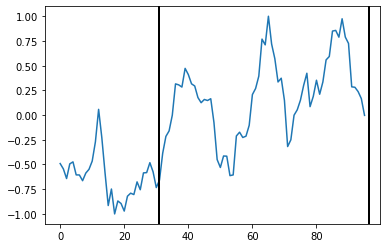

In [97]:
_pat = 3
_i_ = np.where(classifications[0][:,_pat]>_threshold)[0]
#_rc = np.random.choice(_i)
_rc = random.randint(0,_i_.shape[0]-1)
plt.plot(input_data[_i_[_rc]])
plt.axvline(classifications[1][_i_[_rc],0]*96,color="black",linewidth = 2)
plt.axvline((classifications[1][_i_[_rc],0]+classifications[1][_i_[_rc],1])*96,color="black",linewidth = 2)
plt.show()

In [ ]:
def create_model():
    
    i = keras.layers.Input(shape = (96,))
    e = keras.layers.Reshape((96,1))(i)
    
    e = conv_block(_input = e,_filters = 8,_kernel = 3,_pooling = 2)
    #  48 

    e = conv_block(_input = e,_filters = 16,_kernel = 3,_pooling = 2)
    #  24 

    e3 = conv_block(_input = e,_filters = 32,_kernel = 3,_pooling = 2)    
    #  12 

    e2 = conv_block(_input = e3,_filters = 64,_kernel = 3,_pooling = 2)    
    #  6 

    e1 = conv_block(_input = e2,_filters = 128,_kernel = 3,_pooling = 2)    
    #  3 

    # e0 = keras.layers.Conv1D(48,kernel_size = 1,activation = "relu",padding="same")(e0)
    # e0 = keras.layers.Flatten()(e0)

    e1 = keras.layers.Conv1D(64,kernel_size = 1,activation = "relu",padding="same")(e1)
    e1 = keras.layers.Flatten()(e1)

    e2 = keras.layers.Conv1D(32,kernel_size = 1,activation="relu",padding="same")(e2)
    e2 = keras.layers.Flatten()(e2)

    e3 = keras.layers.Conv1D(16,kernel_size = 1,activation="relu",padding="same")(e3)
    e3 = keras.layers.Flatten()(e3)

    #e0 = tf.expand_dims(e0,axis = -2)
    e1 = tf.expand_dims(e1,axis = -2)
    e2 = tf.expand_dims(e2,axis=-2)
    e3 = tf.expand_dims(e3,axis=-2)

    e = keras.layers.Concatenate(axis=-2)([e1,e2,e3])#([e0,e1,e2,e3])

    c = keras.layers.LocallyConnected1D(48,kernel_size = 1,activation = "relu")(e)
    c = keras.layers.BatchNormalization()(c)

    c = keras.layers.Conv1D(96,kernel_size = 3,activation = "relu")(c)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv1D(48,kernel_size = 1,activation = "relu")(c)
    c = keras.layers.BatchNormalization()(c)

    c = keras.layers.Conv1D(4,kernel_size = 1,activation="sigmoid")(c)
    c = keras.layers.Flatten()(c)

    d = keras.layers.LocallyConnected1D(48,kernel_size = 1,activation = "relu")(e)
    d = keras.layers.BatchNormalization()(d)
    
    d = keras.layers.Conv1D(96,kernel_size = 3,activation = "relu")(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Conv1D(48,kernel_size = 1,activation = "relu")(d)
    d = keras.layers.BatchNormalization()(d)

    d = keras.layers.Conv1D(2,kernel_size = 1,activation="relu")(d)
    d = keras.layers.Flatten()(d)
    
    
    model = keras.models.Model(inputs = i, outputs = [c,d])
    model.compile(loss = [keras.losses.binary_crossentropy,keras.losses.mse],optimizer = keras.optimizers.Adam(1e-3),metrics=["accuracy"])
    return model

In [157]:
def create_model():
    
    _input = keras.layers.Input(shape = (96,))
    
    layers = []
    for i in range(16):
        d = keras.layers.Dense(3,activation="relu")(_input)
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(3,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers.append(d)

    layers2 = []
    for i in range(len(layers)):
        d = keras.layers.Dense(5,activation="relu")(layers[i])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(5,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers2.append(d)
    
    layers3 = []
    for i in range(len(layers)):
        d = keras.layers.Dense(7,activation="relu")(layers2[i])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(7,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers3.append(d)

    layers4 = []
    for i in range(len(layers)):
        d = keras.layers.Dense(5,activation="relu")(layers3[i])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(5,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers4.append(d)
    
    d = keras.layers.Concatenate()(layers4)
    d = keras.layers.Dense(5,activation="sigmoid")(d)
    
    
    model = keras.models.Model(inputs = _input, outputs = d)
    model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(1e-3),metrics=["accuracy"])
    return model

In [158]:
def create_model():
    
    i = keras.layers.Input(shape = (96,))
    e = keras.layers.Reshape((96,1))(i)
    
    e = conv_block(_input = e,_filters = 4,_kernel = 3,_pooling = 2)
    #  48 x 48 x 16

    e = conv_block(_input = e,_filters = 8,_kernel = 3,_pooling = 2)
    #  24 x 24 x 32

    e3 = conv_block(_input = e,_filters = 16,_kernel = 3,_pooling = 2)    
    #  12 x 12 x 64

    e2 = conv_block(_input = e3,_filters = 32,_kernel = 3,_pooling = 2)    
    #  6 x 6 x 128

    e1 = conv_block(_input = e2,_filters = 64,_kernel = 3,_pooling = 2)    
    #  3 x 3 x 256
    
    e1 = keras.layers.Conv1D(32,kernel_size = 1,activation = "relu",padding="same")(e1)
    e1 = keras.layers.Flatten()(e1)

    e2 = keras.layers.Conv1D(16,kernel_size = 1,activation="relu",padding="same")(e2)
    e2 = keras.layers.Flatten()(e2)

    e3 = keras.layers.Conv1D(8,kernel_size = 1,activation="relu",padding="same")(e3)
    e3 = keras.layers.Flatten()(e3)

    e1 = tf.expand_dims(e1,axis = -2)
    e2 = tf.expand_dims(e2,axis=-2)
    e3 = tf.expand_dims(e3,axis=-2)

    e = keras.layers.Concatenate(axis=-2)([e1,e2,e3])
    e = keras.layers.LocallyConnected1D(96,kernel_size = 1,activation="relu")(e)
    e = keras.layers.BatchNormalization()(e)
    e = keras.layers.LocallyConnected1D(96,kernel_size = 3,activation="relu")(e)
    e = keras.layers.BatchNormalization()(e)
    # e = keras.layers.Conv1D(96,kernel_size = 1,activation="relu",padding="same")(e)
    # e = keras.layers.BatchNormalization()(e)
    e = keras.layers.LocallyConnected1D(5,kernel_size = 1,activation="sigmoid")(e)
    e = keras.layers.Flatten()(e)
    
    
    model = keras.models.Model(inputs = i, outputs = e)
    model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(1e-3),metrics=["accuracy"])
    return model

In [ ]:
def create_model():
    
    _input = keras.layers.Input(shape = (96,))
    
    layers = []
    for i in range(8):
        d = keras.layers.Dense(3,activation="relu")(_input)
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(3,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers.append(d)

    layers2 = []
    for i in range(len(layers)*2):
        d = keras.layers.Dense(3,activation="relu")(layers[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(3,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers2.append(d)
    
    layers3 = []
    for i in range(len(layers2)*2):
        d = keras.layers.Dense(3,activation="relu")(layers2[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(3,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers3.append(d)

    layers4 = []
    for i in range(len(layers3)*2):
        d = keras.layers.Dense(4,activation="relu")(layers3[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(4,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers4.append(d)
    
    d = keras.layers.Concatenate()(layers4)
    d = keras.layers.Dense(5,activation="sigmoid")(d)
    
    
    model = keras.models.Model(inputs = _input, outputs = d)
    model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(1e-4),metrics=["accuracy"])
    return model

In [ ]:
def create_model():
    
    _input = keras.layers.Input(shape = (96,))
    
    layers = []
    for i in range(16):
        d = keras.layers.Dense(3,activation="relu")(_input)
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(3,activation="relu")(d)
        d = keras.layers.BatchNormalization()(d)
        layers.append(d)
    
    layers2 = []
    for i in range(len(layers)*2):
        d = keras.layers.Dense(3,activation="relu")(layers[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        # d = keras.layers.Dense(3,activation=tf.math.sin)(d)
        # d = keras.layers.BatchNormalization()(d)
        layers2.append(d)

    layers3 = []
    for i in range(len(layers2)*2):
        d = keras.layers.Dense(3,activation="relu")(layers2[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        # d = keras.layers.Dense(1,activation=tf.math.sin)(d)
        # d = keras.layers.BatchNormalization()(d)
        layers3.append(d)

    layers4 = []
    for i in range(len(layers3)*2):
        d = keras.layers.Dense(3,activation="relu")(layers3[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        layers4.append(d)
    
    layers5 = []
    for i in range(len(layers4)*2):
        d = keras.layers.Dense(3,activation="relu")(layers4[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        layers5.append(d)
    
    layers6 = []
    for i in range(len(layers5)*2):
        d = keras.layers.Dense(3,activation="relu")(layers5[int(i*0.5)])
        d = keras.layers.BatchNormalization()(d)
        d = keras.layers.Dense(5,activation="sigmoid")(d)
        d = tf.expand_dims(d,axis=-1)
        layers6.append(d)
    
    d = keras.layers.Concatenate()(layers6)
    d = keras.layers.GlobalAveragePooling1D(data_format = "channels_first")(d)
    # d = keras.layers.Concatenate()(layers4)
    # d = keras.layers.Flatten()(d)
    # # d = keras.layers.Dense(96,activation="relu")(d)
    # # d = keras.layers.BatchNormalization()(d)
    # # d = keras.layers.Dense(96,activation="relu")(d)
    # # d = keras.layers.BatchNormalization()(d)
    # d = keras.layers.Dense(5,activation="sigmoid")(d)
    
    
    model = keras.models.Model(inputs = _input, outputs = d)
    model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(1e-3),metrics=["accuracy"])
    return model

In [ ]:
e = keras.layers.BatchNormalization()(e)
    e = keras.layers.Conv1D(4,kernel_size = 1,activation="relu")(e)
    e = keras.layers.BatchNormalization()(e)

    c = keras.layers.Conv1D(16,kernel_size = 4,activation="relu")(e)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Conv1D(4,kernel_size = 1,activation="sigmoid")(c)
    c = keras.layers.Flatten()(c)

    d = keras.layers.Conv1D(16,kernel_size = 4,activation="relu")(e)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Conv1D(1,kernel_size = 1,activation="relu")(d)
    d = keras.layers.Flatten()(d)

In [ ]:
def create_model():
    
    i = keras.layers.Input(shape = (96,))
    e = keras.layers.Reshape((96,1))(i)
    
    e = conv_block(_input = e,_filters = 4,_kernel = 3,_pooling = 2)
    #  48 

    e = conv_block(_input = e,_filters = 8,_kernel = 3,_pooling = 2)
    #  24 

    e3 = conv_block(_input = e,_filters = 16,_kernel = 3,_pooling = 2)    
    #  12 

    e2 = conv_block(_input = e3,_filters = 32,_kernel = 3,_pooling = 2)    
    #  6 

    e1 = conv_block(_input = e2,_filters = 64,_kernel = 3,_pooling = 2)    
    #  3 

    e1 = keras.layers.Conv1D(32,kernel_size = 1,activation = "relu",padding="same")(e1)
    e1 = keras.layers.Flatten()(e1)

    e2 = keras.layers.Conv1D(16,kernel_size = 1,activation="relu",padding="same")(e2)
    e2 = keras.layers.Flatten()(e2)

    e3 = keras.layers.Conv1D(8,kernel_size = 1,activation="relu",padding="same")(e3)
    e3 = keras.layers.Flatten()(e3)

    e = keras.layers.Add()([e1,e2,e3])

    c = keras.layers.Dense(32,activation="relu")(e)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Dense(32,activation="relu")(c)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.Dense(4,activation="sigmoid")(c)    

    d = keras.layers.Dense(32,activation="relu")(e)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Dense(32,activation="relu")(d)
    d = keras.layers.BatchNormalization()(d)
    d = keras.layers.Dense(2,activation="relu")(d)    
    
    
    model = keras.models.Model(inputs = i, outputs = [c,d])
    model.compile(loss = [keras.losses.binary_crossentropy,keras.losses.mse],optimizer = keras.optimizers.Adam(1e-3),metrics=["accuracy"])
    return model